<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [ ]:
! pip install wquantiles 
! pip install pygam
! pip install dmba

from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'


import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 11.8 MB 4.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend
Cloning into 'practical-statistics-for-data-scientists'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 378 (delta 84), reused 94 (delta 27), pack-reused 207
Receiving objects: 100% (378/378), 84.46 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (170/170), done.


In [ ]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

# 1. 나이브 베이즈(naive bayes)

- 주어진 결과에 대해 예측 변수값을 관찰할 확률을 사용하여 예측변수가 주어졌을 때, 결과 $Y=i$를 관찰할 확률을 추정함

- 조건부확률(conditional probability): 어떤 사건(Y = i)이 주어졌을 때, 해당 사건(X = i)을 관찰할 확률 $P({X}{i}|{X}{i})$
  

- 사후확률(posterior probability): 예측 정보를 통합한 후 결과의 확률 (이와 달리, 사전확률에서는 예측변수에 대한 정보를 고려하지 않는다.)

- 예시 : 대출데이터

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical : # dtype = category
loan_data.outcome = loan_data.outcome.astype('category') 
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='') # one hot 인코딩
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('<나이브 베이즈를 통한 확률 계산 : 연체 vs 이행>')
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

<나이브 베이즈를 통한 확률 계산 : 연체 vs 이행>
predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


- 결과 : 연체를 예상

# 2. 판별분석

- 공분산(covariance): 하나의 변수가 다른 변수와 함께 변화하는 정도(유사한 크기와 방향)를 측정하는 지표

  ## $s_{x,z} = \frac{\sum_{n=1}^{n}(x_i - \bar{x})(z_i - \bar{z})}{n-1}$

- 피셔의 선형판별 : 그룹 안의 편차와 다른 그룹간의 편차를 구분. 아래의 비율을 최대화 하는 선형 결합을($w_x x + w_z z$) 찾는다.
 ## $\frac{SS_{\text{사이}}}{SS_{\text{내부}}}$
 - $SS_{\text{사이}}$ : 두 그룹 사이의 편차를 측정한 것의 제곱합
 - $SS_{\text{내부}}$ : 그룹 안의 변동을 측정한 것의 제곱합

- 판별함수(discriminant function): 예측변수에 적용했을 때, 클래스 구분을 최대화하는 함수
- 판별 가중치(discriminant weight): 판별함수를 적용하여 얻은 점수를 말하며, 어떤 클래스에 속할 확률을 추정하는 데 사용된다.

- 예시 : 대출데이터


In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

# 아래 2가지의 예측변수를 통해 예측
predictors = ['borrower_score', 'payment_inc_ratio'] 
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

print('1. LDA 추정 가중치')
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)

print('\n2. LDA 타겟 확률 반환')
print(pred.head())

1. LDA 추정 가중치
                          0
borrower_score     7.175839
payment_inc_ratio -0.099676

2. LDA 타겟 확률 반환
    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


변수2개를 활용한 연체에 대한 LDA 시각화


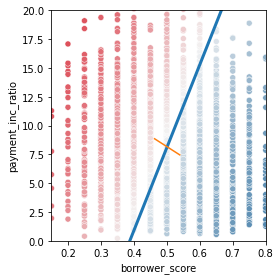

In [ ]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

print('변수2개를 활용한 연체에 대한 LDA 시각화')
plt.tight_layout()
plt.show()

- 대각선 기준 왼쪽의 경우 연체로 예측 된다.

# 3. 로지스틱 회귀

- 로짓(logit): (0~1이 아니라) ±∞의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수 (유의어 : 로그 오즈)
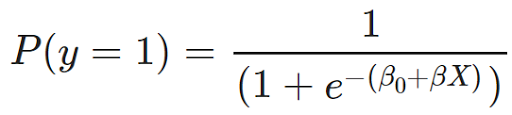
- 오즈(odds): '실패'(0)에 대한 '성공'(1)의 비율
- 로그 오즈(log odds): 변환 모델(선형)의 응답변수. 이 값을 통해 확률을 구한다.
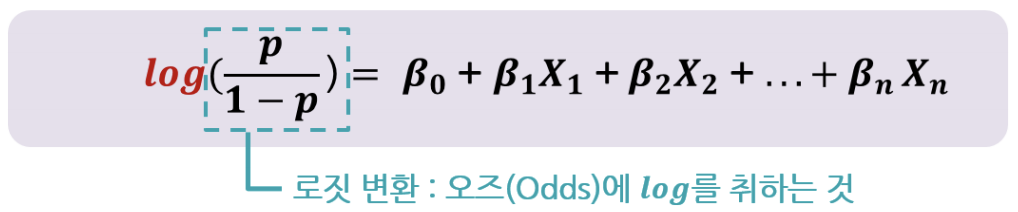

로짓 함수 그래프


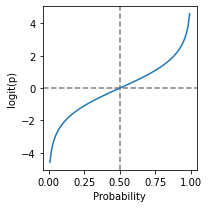

In [ ]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

print('로짓 함수 그래프')
plt.tight_layout()
plt.show()

In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome]

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('<로지스틱 회귀 : 개인 대출 정보 중 여러 변수 사용하여 예측>')
print('intercept(절편) ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff(계수)': logit_reg.coef_[0]}, 
             index=X.columns)

<로지스틱 회귀 : 개인 대출 정보 중 여러 변수 사용하여 예측>
intercept(절편)  -1.6380882883923482
classes ['default' 'paid off']


,coeff(계수)
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


In [ ]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe()) # describe로 데이터 분포 확인 가능

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538865
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


오즈비와 로그 오즈비 사이의 관계


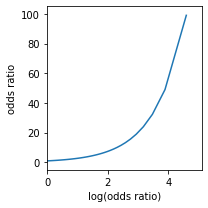

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

print('오즈비와 로그 오즈비 사이의 관계')
plt.tight_layout()
plt.show()

In [ ]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]

logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Tue, 22 Feb 2022   Deviance:                       57515.
Time:                        09:01:24   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [ ]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()

로지스틱 회귀에서 얻은 편잔차


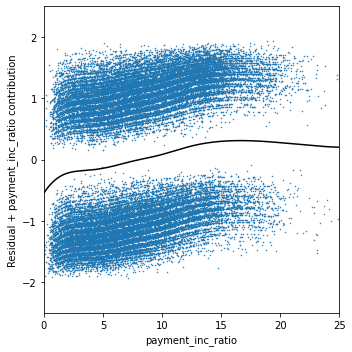

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

print('로지스틱 회귀에서 얻은 편잔차')
plt.tight_layout()
plt.show()

- 검은선은 회귀선이며, 위쪽은 1의 연체를 의미, 아래는 0의 대출 상환을 의미

# 4. 분류 모델 평가하기

- 가장 간단한 방법은 정확도를 예측하는 것 

 $\text{정확도} = \frac{\sum \text{참 양성} + \sum \text{참 음성}}{\text{표본 크기}}$

### 1. 혼돈행렬

- 응답 유형별로 정확한 예측과 잘못된 예측의 수를 한 번에 보여주는 표

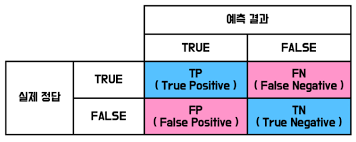

- 예시 : 앞서 계산한 연체 데이터의 로지스틱스 함수를 통해서 혼돈행렬 계산

In [ ]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y   
true_neg = ~true_y & ~pred_y 
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


- 왼쪽 상단부터의 대각선이 올바르게 예측한 결과

In [ ]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


### 2. 정밀도, 재현율, 특이도

- 정밀도 : 예측된 양성 결과의 정확도

 $\text{정확도} = \frac{\sum \text{참 양성}}{\sum \text{참 양성} + \sum \text{거짓 양성}}$

- 재현율=민감도 : 양성 결과를 예측하는 모델의 정확도

 $\text{재현율} = \frac{\sum \text{참 양성}}{\sum \text{참 양성} + \sum \text{거짓 음성}}$

- 특이도 : 음성 결과를 정확히 예측하는 능력

 $\text{특이도} = \frac{\sum \text{참 음성}}{\sum \text{참 음성} + \sum \text{거짓 양성}}$

In [ ]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision(정확도)', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall(재현율)', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity(특이도)', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision(정확도) 0.6376089663760897
Recall(재현율) 0.6323496978518812
Specificity(특이도) 0.6405981209474659


In [ ]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

### 3. ROC 곡선

- x축(특이도)에 대한 y축(재현율)을 표시
- 컷오프 값을 바꿀 때 재현율과 특이도 사이의 트레이드오프 관계를 보여줌
- ROC곡선 계산 과정 : 1로 예측할 확률에 따라 1이 되기 쉬운 것부터~ 어려운 순으로 레코드 정렬. 순서대로 특이도와 재현율을 계산

대출 데이터에 대한 ROC 곡선


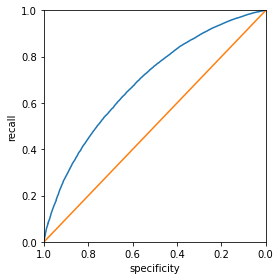

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

print('대출 데이터에 대한 ROC 곡선')
plt.tight_layout()
plt.show()

### 4. AUC

- ROC 곡선의 아래쪽 면적을 의미. AUC 값이 높을 수록 더 좋은 분류기

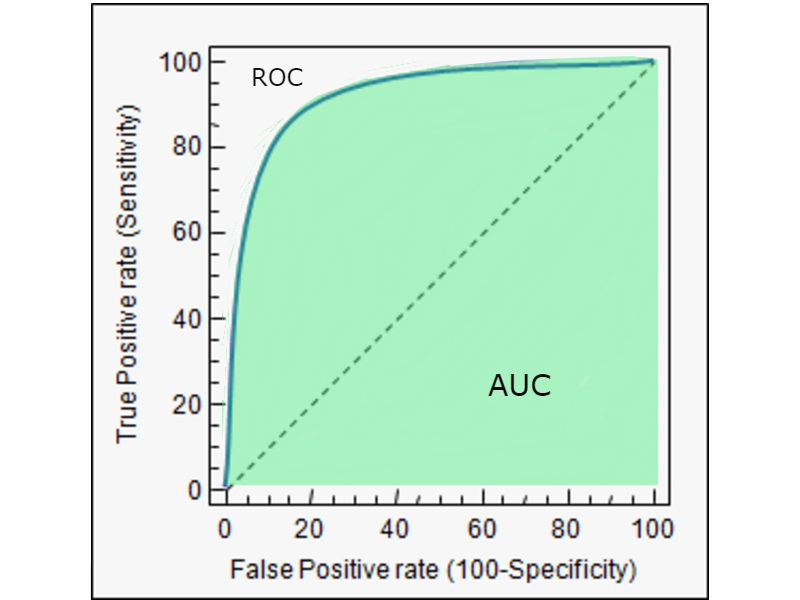

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


- 0.69는 상대적으로 약한 분류기라고 볼 수 있다.

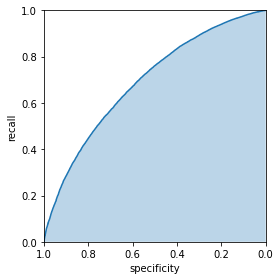

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)

plt.tight_layout()
plt.show()

- 파란색 음영의 면적을 AUC라고 볼 수 있다.

### 5. 이익 도표 & 리프트 곡선 (Gain Chart & Lift curve)

- Gain Chart(이익 도표) : 분류 모형을 사용하여 분류된 관측치가 각 등급별로 얼마나 포함되는지를 나타내는 도표로 다른 집단 또는 전체 집단 대비 몇 배의 효과가 있는지를 확인 함

- 해당 등급에 따라 계산된 이익값을 누적으로 연결함

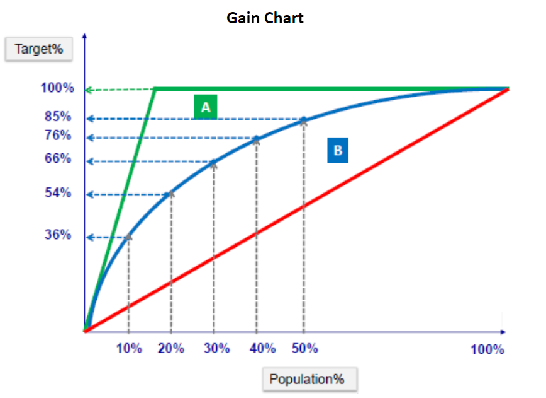

-  Lift curve(향상도 곡선) : 랜덤 모델과 비교했을 때, 해당 모델의 성과가 얼마나 향상되었는지를 각 등급별로 파악하는 그래프

- 리프트는 기본 향상도에 비해 반응률이 몇 배나 높은지를 계산한 수치

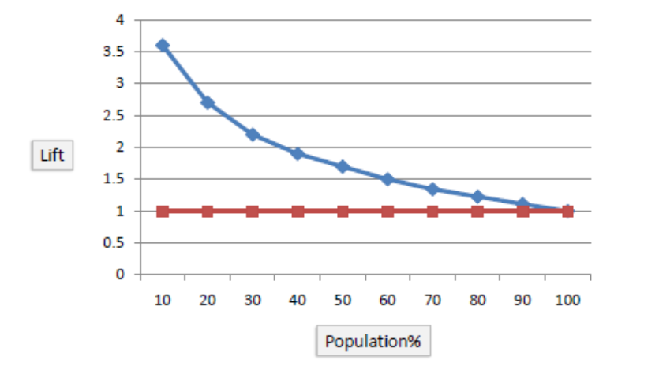

 - 상위 등급에서의 향상도가 매우 크고 하위 등급으로 갈 수록 향상도가 감소하게 되어, 일반적으로 이러한 모형의 예측력이 좋다는 것을 의미하지만, 등급에 관계없이 향상도가 차이가 없게 되면 모형의 예측력이 좋지 않음을 나타낸다. 

- 예를 들어 국세청 감사 시 사용 가능 자원이 한정적이기 때문에 감사를 진행할지 말지 결정하기 위해 리프트 차트를 사용 한다.


# 5. 불균형 데이터 다루기

- 불균형 데이터에서 예측 모델링 성능을 향상할 몇 가지 방법

- 데이터에 불균형이 존재할 경우 보통은 어느 한쪽(1의 클래스)을 정확히 분류하는 것에 더 좋은 점수를 주게 되어 있고, 이러한 가치 비율이 평가 지표에 반영되어야 한다

### 1. 과소표본추출(undersample)

- 과소표본(undersample): 분류 모델에서 갯수가 많은 클래스 데이터 중 일부 소수만을 사용하는 것 (유의어 : 다운샘플)


In [ ]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
print('데이터 형태 :', full_train_set.shape)

print('1. percentage of loans in default(실제 데이터 중 연체 비율): ')
print(100 * np.mean(full_train_set.outcome == 'default'))

predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('\n2. percentage of loans predicted to default(연체라고 예측 결과)')
print(100 * np.mean(full_model.predict(X) == 'default'))


데이터 형태 : (119987, 19)
1. percentage of loans in default(실제 데이터 중 연체 비율): 
18.894546909248504

2. percentage of loans predicted to default(연체라고 예측 결과)
0.9759390600648404


- 실제 약 19%인 결과에 비해 잘못된 예측이 되고 있다.

### 2. 과잉표본(oversample)

- 과잉표본(oversample): 분류 모델에서 희귀 클래스 데이터를 중복해서, 필요하면 부트스트랩 해서 사용하는 것 (유의 : 업샘플)

- 상향 가중치(up weight)혹은 하향 가중치(down weight): 모델에서 희귀(혹은 다수) 클래스에 높은(혹은 낮은) 가중치를 두는 것

In [ ]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]
# 연체에 대한 가중치를 1/p(연체의 확률 값) 적용

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting 가중치): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

61.79836148916132
percentage of loans predicted to default (weighting 가중치):  None


- 예측값이 변경한 것을 볼 수 있다.

### 3. 데이터 생성(data generation)

- 데이터 생성(data generation): 부트스트랩과 비슷하게 다시 샘플링한 레코드를 빼고 원래 원본과 살짝 다르게 데이터를 생성하는 것

- SMOTE(합성 소수 과잉표본 기법) 알고리즘 : 업샘플링된 레코드와 비슷한 레코드를 찾고, 원래 레코드와 이웃 레코드의 랜덤 가중평균으로 새로운 합성 레코드를 만든다. 각각의 예측 변수에 대해 개별적으로 가중치를 생성함

- ADASYN 알고리즘 : SMOTE는 모든 minority class로부터 동일한 개수의 synthetic 샘플을 생성했지만, ADASYN은 각 관측치마다 생성하는 샘플의 수가 다르다는 점이 특징

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('1. percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('2. percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('3. percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('4. percentage of loans predicted to default (ADASYN): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

1. percentage of loans in default (SMOTE resampled):  50.0
2. percentage of loans predicted to default (SMOTE):  29.27733837832432
3. percentage of loans in default (ADASYN resampled):  48.56040383751355
4. percentage of loans predicted to default (ADASYN):  27.913857334544577


1. SMOTE를 이용하여 연체 비율을 50%로 맞춰준다.
2. SMOTE의 데이터를 통해 연체라고 예측한 결과는 29.27%
3. ADASYN를 사용하여 연체 비율을 48.56%로 맞춰준다
4. ADASYN의 데이터를 통해 연체라고 예측한 결과는 27.91%

### 4. 비용 기반 분류

- 실무적으로 AUC만으로 정확도를 구하는게 충분하지 않을 때, 최상의 컷오프 결정을 위해 비용을 종합적으로 고려 필요

 기대수익 = $P(Y=0) \text{ x } R + P(Y=1) \text{ x } C$
 - $Y = 0, 1$ = 대출 상환, 연체
 - $R$ = 대출 상환을 통해 얻을 수 있는 수익
  - $C$ = 신규대출에서 연체로인해 발생할 수 있는 예상 비용

- 결국 사업의 목적인 기대 수익을 결정하기 위해 대출  상품의 전체 가치를 얻어야 한다.

### 5. 예측 결과 분석

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


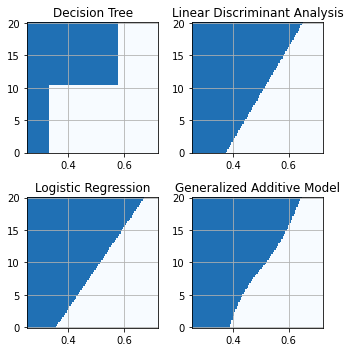

In [ ]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

4개의 서로 다른 분류 모델의 예측 규칙 비교


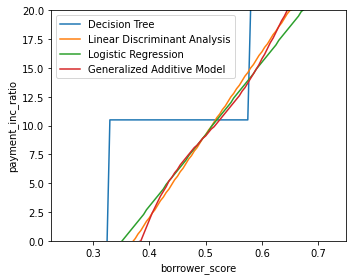

In [ ]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)

print('4개의 서로 다른 분류 모델의 예측 규칙 비교')
plt.tight_layout()
plt.show()

- 선 기준 왼쪽 상단 영역이 연체 예측에 해당 됨
- 최종 적으로 GAM이 다른 선형 모델들을 서로 타협하는 결과를 보여줌